In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/MLGSD/project_2/project_2'    #project folder directory

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd 'gdrive/My Drive/MLGSD/project_2/project_2'

/content/gdrive/My Drive/MLGSD/project_2/project_2


In [0]:
%load_ext autoreload
%autoreload 2
import torch
from torch.optim import Adam
from matplotlib import pyplot as plt
from utils import get_mnist_data
from models import ConvNN
from training_and_evaluation import train_model, predict_model
from attacks import fast_gradient_attack
from  torch.nn.functional import cross_entropy
from typing import Tuple

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Project 2, part 2: Adversarial training (20 pt)
In this notebook we perform advcersarial training on the convolutional neural network from Part 1.

## Your task
Complete the missing code in this notebook. Make sure that all the functions follow the provided specification, i.e. the output of the function exactly matches the description in the docstring. 

Specifically, for this part you will have to implement the following functions / classes:  

**This notebook**
* The `loss_function` used for adversarial training. (20pt)

## General remarks

Do not add or modify any code outside of the following comment blocks, or where otherwise explicitly stated.

``` python
##########################################################
# YOUR CODE HERE
...
##########################################################
```
After you fill in all the missing code, restart the kernel and re-run all the cells in the notebook.

The following things are **NOT** allowed:
- Using additional `import` statements
- Copying / reusing code from other sources (e.g. code by other students)

If you plagiarise even for a single project task, you won't be eligible for the bonus this semester.

In [0]:
mnist_trainset = get_mnist_data(train=True)
mnist_testset = get_mnist_data(train=False)
use_cuda = torch.cuda.is_available() #and False

model = ConvNN()
if use_cuda:
    model = model.cuda()

epochs = 2
batch_size = 128
test_batch_size = 1000  # feel free to change this
lr = 1e-3

opt = Adam(model.parameters(), lr=lr)

attack_args = {'norm': "2", "epsilon": 5}

### Loss function



In [0]:
def loss_function(x: torch.Tensor, y: torch.Tensor, model: torch.nn.Module,  **attack_args) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Loss function used for adversarial training. First computes adversarial examples on the input batch via fast_gradient_attack and then computes the logits
    and the loss on the adversarial examples.
    Parameters
    ----------
    x: torch.Tensor of shape [B, C, N, N], where B is the batch size, C is the number of channels, and N is the image width/height.
        The input batch to certify.
    y: torch.Tensor of shape [B, 1].
        The labels of the input batch.
    model: torch.nn.Module
        The classifier to be evaluated.
    attack_args: additional arguments passed to the adversarial attack function.
    
    Returns
    -------
    Tuple containing
        * loss_pert: torch.Tensor, shape [B,]
            The loss obtained on the adversarial examples.
        * logits_pert: torch.Tensor, shape [B, K], where K is the number of classes.
            The logits obtained on the adversarial examples
    """
    ##########################################################
    # YOUR CODE HERE
    x = x.to(model.device())
    x.requires_grad = True
    logits = model(x).cpu()
    model.zero_grad()
    x_pert = fast_gradient_attack(logits, x, y, attack_args["epsilon"], attack_args["norm"])
    model.zero_grad()
    logits_pert = model(x_pert).cpu()
    loss_pert = cross_entropy(logits_pert,y)
    ##########################################################
    # Important: don't forget to call model.zero_grad() after creating the adversarial examples.
    return loss_pert, logits_pert

In [0]:
losses, accuracies = train_model(model, mnist_trainset, batch_size=batch_size, loss_function=loss_function, optimizer=opt, loss_args=attack_args, epochs=epochs)

In [0]:
torch.save(model.state_dict(), "models/adversarial_training.checkpoint")

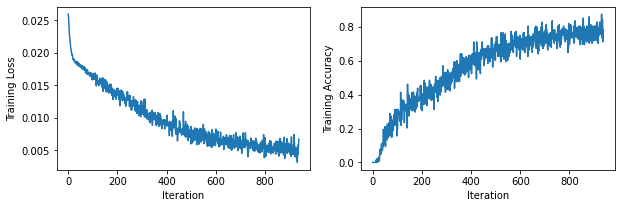

In [0]:
fig = plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.subplot(122)
plt.plot(accuracies)
plt.xlabel("Iteration")
plt.ylabel("Training Accuracy")
plt.show()

In [0]:
clean_accuracy = predict_model(model, mnist_testset, batch_size=test_batch_size, attack_function=None)

In [0]:
perturbed_accuracy = predict_model(model, mnist_testset, batch_size=test_batch_size, attack_function=fast_gradient_attack, attack_args=attack_args)

In [0]:
clean_accuracy

0.9298999905586243

In [0]:
perturbed_accuracy

0.7865999937057495